In [1]:
import scanpy as sc

In [2]:
import pandas as pd
import numpy as np
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [3]:
import os

In [4]:
import matplotlib.pyplot as plt

In [5]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

### Prepare sc data

In [6]:
adata = sc.read('zenodo/sarcoma.h5ad')

In [7]:
adata.obs['label'] = adata.obs['level2_cell_type']

In [8]:
adata.obs['replicate'] = adata.obs['dataset']

In [9]:
adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [10]:
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")

In [11]:
del adata.obsp
del adata.uns
adata.obsm.pop('X_scVI')

array([[-0.6677396 , -0.04581606, -2.8869205 , ..., -0.59034467,
        -1.3803416 ,  0.90400046],
       [ 0.858954  , -1.2645198 ,  0.27933836, ...,  0.19097352,
         0.19701934, -1.1516061 ],
       [ 0.5574781 , -1.0408107 ,  0.4365765 , ..., -0.57438195,
         0.8717618 , -1.175303  ],
       ...,
       [-0.3602912 , -1.3089345 ,  1.2928166 , ...,  0.74338293,
         0.57259405, -0.22434264],
       [-0.00928557, -0.5428895 ,  0.80738664, ...,  0.07477224,
         0.39288878,  0.2390346 ],
       [-0.37373438, -1.1714759 ,  0.5201833 , ...,  0.78470707,
         0.21368921, -0.7697572 ]], dtype=float32)

In [12]:
adata.obs['cellstate'] = adata.obs['label']

In [13]:
cellstate_celltype_dict = {'B cells' : 'B cells', 'CD56bright NK cells' : 'NK cells', 'CD56dim NK cells' : 'NK cells', 'Dendritic cells' : 'Myeloid',
       'Endothelial cells' : 'Endothelial cells', 'Epithelial Stroma' : 'Epithelial Stroma', 'Fibroblasts' : 'Fibroblasts', 'ILCs' : 'ILCs', 'Late erythroid' : 'Late erythroid',
       'MAIT cells' : 'T cells', 'Macrophages' : 'Myeloid', 'Mast cells' : 'Myeloid', 'NKT cells' : 'NKT cells', 'Plasma cells' : 'B cells',
       'Melanoma cells' : 'Melanoma cells', 'Memory B cells' : 'B cells', 'Monocytes' : 'Myeloid', 'Regulatory T cells' : 'T cells',
       'Tcm/Naive helper T cells' : 'T cells', 'Tem/Effector helper T cells' : 'T cells',
       'Tem/Trm cytotoxic T cells' : 'T cells', 'Type 1 helper T cells' : 'T cells', 'CAFs' : 'CAFs', 'Osteoblasts' : 'Osteoblasts', 'Osteoclasts' : 'Osteoclasts', 'Tcm/Naive cytotoxic T cells' : 'T cells'}

In [14]:
adata.obs['celltype'] = [cellstate_celltype_dict[x] for x in adata.obs['cellstate']]

In [15]:
adata_subsample = adata#sc.pp.subsample(adata, fraction=0.1, copy=True)

In [16]:
%%R -i adata_subsample
adata_subsample

class: SingleCellExperiment 
dim: 21505 150851 
metadata(0):
assays(1): X
rownames(21505): FAM138A OR4F5 ... MT-ND6 MT-CYB
rowData names(6): mt ribo ... pct_dropout_by_counts total_counts
colnames(150851): AAACCCAAGACTTCCA-1-GSM5155200_liu_GSM5155200
  AAACCCAAGACTTCGT-1-GSM5155200_liu_GSM5155200 ...
  TTTGTCAGTAGCCTAT-1_P4_cillo_cillio_osteosarcoma_4
  TTTGTCATCGTTACAG-1_P4_cillo_cillio_osteosarcoma_4
colData names(20): sample patient ... cellstate celltype
reducedDimNames(1): UMAP
mainExpName: NULL
altExpNames(0):


In [17]:
%%R
sc.dat <- t(assay(adata_subsample))

In [18]:
%%R
sc.dat <- as.matrix(sc.dat)

In [19]:
%%R
cell.type.labels <- colData(adata_subsample)$celltype

In [20]:
%%R
cell.type.labels <- as.vector(cell.type.labels)

In [21]:
%%R
cell.state.labels <- colData(adata_subsample)$cellstate

In [22]:
%%R
cell.state.labels <- as.vector(cell.state.labels)

### download and prepare tcga data

In [6]:
%%R
library(TCGAbiolinks)

In [7]:
%%R
library(scran)

In [8]:
%%R
my.dir = '/tumor-data/GDCdata'

# Gene expression aligned against hg38
query <- GDCquery(
    project = "TARGET-OS",
    data.category = "Transcriptome Profiling",
    data.type = "Gene Expression Quantification", 
    workflow.type = "STAR - Counts"
)
#GDCdownload(query = query,
#            directory = "/tumor-data/GDCdata")

data <- GDCprepare(query = query,
                   directory = my.dir,
                   save = TRUE,
                   save.filename = "/tumor-data/SARC_OS_exp.rda")

|====================================================|100% ~0 s remaininginingg                                                                                                                                                                                       Completed after 11 m 


In [9]:
%%R
bk.mtx <- assay(data)

In [10]:
%%R
rownames(bk.mtx) <- rowData(data)$gene_name

In [11]:
%%R
bk.dat <- t(bk.mtx)

In [12]:
%%R
clin.dat <- GDCquery_clinic("TARGET-OS", "clinical")

In [13]:
%%R
colnames(bk.dat) <- make.unique(colnames(bk.dat), sep = ".")

In [14]:
%%R
dim(bk.dat)

[1]    88 60660


### BayesPrism

In [32]:
%%R
library(BayesPrism)

In [33]:
%%R
sc.dat.filtered <- cleanup.genes (input=sc.dat, input.type="count.matrix",
                                  species="hs",
                                  gene.group=c( "Rb","Mrp","other_Rb","chrM","MALAT1","chrX","chrY") , exp.cells=5)

Gene symbols detected. Recommend to use EMSEMBLE IDs for more unique mapping.
number of genes filtered in each category: 
      Rb      Mrp other_Rb     chrM   MALAT1     chrX     chrY 
      89       78       17       13        1      882      115 
A total of  1154  genes from Rb Mrp other_Rb chrM MALAT1 chrX chrY  have been excluded 
A total of  2074  gene expressed in fewer than  5  cells have been excluded 


In [34]:
%%R
dim(sc.dat.filtered)

[1] 150851  18277


In [35]:
%%R
myPrism <- new.prism(reference=sc.dat.filtered,
                     mixture=bk.dat,
                     input.type="count.matrix",
                     cell.type.labels = cell.type.labels,
                     cell.state.labels = cell.state.labels,
                     key=NULL,
                     outlier.cut=0.01,
                     outlier.fraction=0.1,
)

number of cells in each cell state 
cell.state.labels
                    B cells                 Osteoclasts 
                         30                          31 
                Fibroblasts Tcm/Naive cytotoxic T cells 
                        105                         272 
        CD56bright NK cells                 Osteoblasts 
                        359                         395 
Tem/Effector helper T cells              Memory B cells 
                        454                        1005 
            Dendritic cells                Plasma cells 
                       1057                        1319 
         Regulatory T cells            CD56dim NK cells 
                       1339                        1357 
                  NKT cells    Tcm/Naive helper T cells 
                       1405                        1630 
                  Monocytes           Endothelial cells 
                       1884                        4891 
  Tem/Trm cytotoxic T cells       

In [36]:
%%R
bp.res <- run.prism(prism = myPrism, n.cores=5)

Run Gibbs sampling... 
Current time:  2023-11-21 18:08:38 
Estimated time to complete:  1days 8hrs 2mins 
Estimated finishing time:  2023-11-23 02:10:03 
Start run... 
R Version:  R version 4.2.3 (2023-03-15) 

Update the reference matrix ... 
Run Gibbs sampling using updated reference ... 
Current time:  2023-11-21 18:43:11 
Estimated time to complete:  60mins 
Estimated finishing time:  2023-11-21 19:42:40 
Start run... 


In [16]:
%%R -o Z_nk,Z_nk_colnames,Z_nk_rownames
Z_nk <- get.exp(bp.res, state.or.type='type', cell.name='NK cells')
Z_nk_colnames <- colnames(Z_nk)
Z_nk_rownames <- rownames(Z_nk)

In [17]:
Z_nk = pd.DataFrame(Z_nk,index=Z_nk_rownames,columns=Z_nk_colnames) ### NK expression matrix (patients x genes)

In [18]:
Z_nk_adata = sc.AnnData(Z_nk)

In [19]:
Z_nk_adata

AnnData object with n_obs × n_vars = 88 × 17842

In [20]:
%%R -o theta,theta_colnames,theta_rownames
theta <- get.fraction(bp=bp.res, 
                       which.theta="final",
                       state.or.type="type")

theta_colnames <- colnames(theta)
theta_rownames <- rownames(theta)

In [21]:
%%R -o theta_state,theta_state_colnames,theta_state_rownames
theta_state <- get.fraction(bp=bp.res, 
                       which.theta="first",
                       state.or.type="state")

theta_state_colnames <- colnames(theta_state)
theta_state_rownames <- rownames(theta_state)

In [22]:
theta_type_df = pd.DataFrame(theta,index=theta_rownames,columns=theta_colnames) ### Cell type fractions (patients x cell types)

In [23]:
theta_state_df = pd.DataFrame(theta_state,index=theta_state_rownames,columns=theta_state_colnames) ### Cell state fractions (patients x cell states)

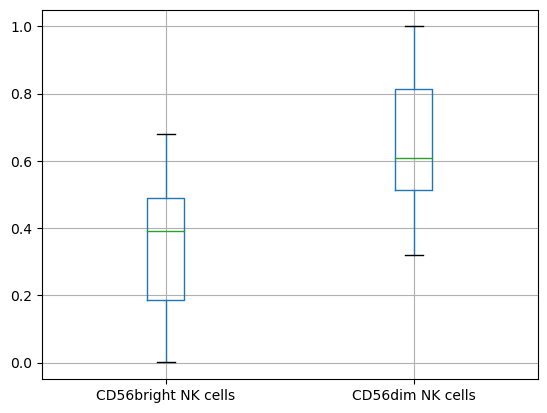

In [24]:
bp_plot = pd.DataFrame(theta_state_df[['CD56bright NK cells', 'CD56dim NK cells']].T/theta_state_df[['CD56bright NK cells', 'CD56dim NK cells']].sum(axis=1).T).T.boxplot()

In [25]:
figure = bp_plot.get_figure()    
figure.savefig('cd56bright_cd56dim_sarcoma_tcga.pdf', dpi=400)

In [26]:
theta_state_groups = theta_state_df[['CD56bright NK cells', 'CD56dim NK cells']].copy()

In [27]:
theta_type_immune = theta_type_df[['T cells', 'Myeloid', 'B cells', 'NK cells', 'NKT cells',]].copy()

In [28]:
theta_type_immune.index = ['-'.join(x.split('-')[:3]) for x in theta_type_immune.index]

In [29]:
theta_type_immune = theta_type_immune[~theta_type_immune.index.duplicated(keep='first')]

In [30]:
theta_state_groups.index = ['-'.join(x.split('-')[:3]) for x in theta_state_groups.index]

In [31]:
theta_state_groups = theta_state_groups[~theta_state_groups.index.duplicated(keep='first')]

In [32]:
theta_state_groups_fraction = (theta_state_groups.T/theta_state_groups.sum(axis=1)).T.copy()

In [33]:
theta_type_immune_fraction = (theta_type_immune.T/theta_type_immune.sum(axis=1)).T.copy()

#### Clinical SARC

In [36]:
%%R -o clin_sarc
clin_sarc <- clin.dat[1:20]

In [37]:
sarc_survival_df = pd.read_csv('/tumor-data/TARGET-OS.survival.tsv', sep='\t')

In [38]:
sarc_survival_df = sarc_survival_df.drop_duplicates(subset='_PATIENT')

In [39]:
clin_sarc = clin_sarc[[x in theta_type_immune.index for x in clin_sarc['submitter_id']]]

In [40]:
sarc_survival_df.index = sarc_survival_df['_PATIENT']

In [41]:
clin_sarc = clin_sarc[[x in sarc_survival_df.index for x in clin_sarc['submitter_id']]]

In [42]:
sarc_survival_df = sarc_survival_df.loc[clin_sarc['submitter_id']].copy()

In [43]:
clin_sarc.loc[:,sarc_survival_df.columns] = sarc_survival_df.values

/tmp/ipykernel_423903/3320016945.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clin_sarc.loc[:,sarc_survival_df.columns] = sarc_survival_df.values


In [44]:
clin_sarc['total_nk'] = ['high' if x in theta_type_immune.sort_values('NK cells')[-int(theta_type_immune.shape[0]/3):].index 
                        else 'low' if x in theta_type_immune.sort_values('NK cells')[:int(theta_type_immune.shape[0]/3)].index else 'middle' for x in clin_sarc['submitter_id']]

In [45]:
cell_state='CD56bright NK cells'
clin_sarc['cd56bright'] = ['high' if x in theta_state_groups.sort_values(cell_state)[-int(theta_state_groups.shape[0]/3):].index 
                                          else 'low' if x in theta_state_groups.sort_values(cell_state)[:int(theta_state_groups.shape[0]/3)].index else 'middle' for x in clin_sarc['submitter_id']]

In [46]:
cell_state='CD56dim NK cells'
clin_sarc['cd56dim'] = ['high' if x in theta_state_groups.sort_values(cell_state)[-int(theta_state_groups.shape[0]/3):].index 
                                          else 'low' if x in theta_state_groups.sort_values(cell_state)[:int(theta_state_groups.shape[0]/3)].index else 'middle' for x in clin_sarc['submitter_id']]

#### Stratify by NK, CD56bright and CD56dim

In [61]:
test_group='total_nk'

In [62]:
clin_sarc_test = clin_sarc[clin_sarc[f'{test_group}'] != 'middle'].copy()

In [63]:
%%R
library(survival)
library("survminer")

In [64]:
%%R -i clin_sarc_test
clin_sarc_test$OS=as.numeric(clin_sarc_test$OS)
clin_sarc_test$OS.time=as.numeric(clin_sarc_test$OS.time)

clin_sarc_test$OS.time <- clin_sarc_test$OS.time / 365

clin_sarc_test$OS[clin_sarc_test$OS.time>7] <- 0
clin_sarc_test$OS.time[clin_sarc_test$OS.time>7] <- 7

clin_sarc_test$OS.use=clin_sarc_test$OS
clin_sarc_test$OS.time.use=clin_sarc_test$OS.time

In [65]:
#%%R
#cox = coxph(Surv(OS.time.use,OS.use) ~ g1 + gender + age_at_index + ajcc_pathologic_stage, data=clin_sarc_test)

In [66]:
%%R -i test_group
#form = as.formula(paste('Surv(OS.time.use,OS.use)', '~', test_group))
fit = survfit(as.formula(paste('Surv(OS.time.use,OS.use)', '~', test_group)), data=clin_sarc_test)

In [67]:
%%R
dir=""
cancer=paste('SARC', '_', test_group)
p = ggsurvplot(fit, clin_sarc_test, size=0.3, vlegend.labs=unique(clin_sarc_test[[test_group]]),
                   surv.median.line="none", pval=T, conf.int=F,
                   palette=c("#CCCCCC","#990066"),title=cancer) + 
                   xlab("Years")
    
pdf(file=sprintf("survival_%s.pdf", cancer), width=3, height=3,onefile = FALSE)
print(p)
dev.off()

png 
  2 


#### Score NK cell states

In [68]:
from pyscenic.aucell import aucell
from ctxcore.genesig import GeneSignature
from pyscenic.aucell import create_rankings, enrichment

In [69]:
all_groups_deg = pd.read_csv('nhood_markers_DEG_all_groups.csv')

In [70]:
for group in range(1,7):
    all_groups_deg[f'rank_{group}'] = all_groups_deg[f'logFC_{group}']*-np.log10(all_groups_deg[f'adj.P.Val_{group}'])

In [71]:
group = 1
g1_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-20:]['GeneID'])

In [72]:
group = 3
g2_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-20:]['GeneID'])

In [73]:
group = 2
g3_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-20:]['GeneID'])

In [74]:
group = 4
g4_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-20:]['GeneID'])

In [75]:
group = 5
g5_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-20:]['GeneID'])

In [76]:
group = 6
g6_sig = np.array(all_groups_deg.sort_values(f'rank_{group}')[-20:]['GeneID'])

In [77]:
signature_genes = [g1_sig,g2_sig,g3_sig,g4_sig,g5_sig,g6_sig]
signature_names = [f'g{x}' for x in range(1,7)]

In [92]:
gene_sigs = [GeneSignature(name,genes) for (name,genes) in zip(signature_names, signature_genes)]

In [93]:
exp_df = Z_nk_adata.to_df()#pd.DataFrame(adata.X.todense(), columns=adata.var.index, index=adata.obs.index)

In [147]:
import random

In [148]:
random.seed(0)

In [149]:
auc_mtx = aucell(exp_df, gene_sigs, normalize=True, num_workers=4)

In [150]:
auc_mtx.index = ['-'.join(x.split('-')[:3]) for x in auc_mtx.index]

In [151]:
auc_mtx = auc_mtx[~auc_mtx.index.duplicated(keep='first')]

In [152]:
auc_mtx = auc_mtx.loc[clin_sarc['submitter_id']]

In [153]:
for i in range(1,7):
    nk_state=i
    clin_sarc[f'g{nk_state}'] = ['high' if x in auc_mtx.sort_values(f'g{nk_state}')[-int(auc_mtx.shape[0]/2):].index 
                                else 'low' if x in auc_mtx.sort_values(f'g{nk_state}')[:int(auc_mtx.shape[0]/2)].index else 'middle' for x in clin_sarc['submitter_id']]

In [154]:
clin_sarc['g1g3'] = [f'{x[:2]}_{y[:2]}' for x,y in zip(clin_sarc['g1'], clin_sarc['g3'])]

In [155]:
clin_sarc_test = clin_sarc[clin_sarc['g1g3'].isin(['lo_hi', 'hi_lo'])].copy()

In [156]:
%%R
library(survival)
library("survminer")

In [157]:
%%R -i clin_sarc_test
clin_sarc_test$OS=as.numeric(clin_sarc_test$OS)
clin_sarc_test$OS.time=as.numeric(clin_sarc_test$OS.time)

clin_sarc_test$OS.time <- clin_sarc_test$OS.time / 365

clin_sarc_test$OS[clin_sarc_test$OS.time>7] <- 0
clin_sarc_test$OS.time[clin_sarc_test$OS.time>7] <- 7

clin_sarc_test$OS.use=clin_sarc_test$OS
clin_sarc_test$OS.time.use=clin_sarc_test$OS.time

In [158]:
#%%R
#cox = coxph(Surv(OS.time.use,OS.use) ~ g1 + gender + age_at_index + ajcc_pathologic_stage, data=clin_sarc_test)

In [159]:
%%R
fit = survfit(Surv(OS.time.use,OS.use) ~ g1g3, data=clin_sarc_test)

In [160]:
%%R
dir=""
cancer='SARC_g1g3'
p = ggsurvplot(fit, clin_sarc_test, size=0.3, vlegend.labs=unique(clin_sarc_test$g1g3),
                   surv.median.line="none", pval=T, conf.int=F,
                   #risk.table=T, risk.table.y.text.col=T,
                   palette=c("#990066","#CCCCCC"),title=cancer) + 
                   xlab("Years")
    
pdf(file=sprintf("survival_%s.pdf", cancer), width=3, height=3,onefile = FALSE)
print(p)
dev.off()

png 
  2 
